# evaluation enformer 2

We have models that use an encoder, let's adapt our old code to see what they do

The loss is exactly 1 which is a little bit sus

In [10]:
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
import src.dataloaders.datasets.enformer_dataset as enformer_dataset

#these are the only things we modify
dataset = enformer_dataset.EnformerDataset('test', 131_072, rc_aug = False, load_into_memory=False, cell_type=121)

ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-07-26/23-07-35-355495/checkpoints/00-val_loss=1.00000.ckpt'

In [11]:
import yaml
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/enformer.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

model_cfg['layer']['l_max'] = 1026

# d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
# print(d_output, model_cfg, train_cfg)
d_output = 1
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.tasks.decoders import EnformerDecoder
from src.tasks.encoders import EnformerEncoder
import torch
backbone = DNAEmbeddingModel(**model_cfg)
decoder = EnformerDecoder(256, l_output=0, mode='pool', d_output=d_output, convolutions=False, downsampled=128)
encoder = EnformerEncoder(d_model = 256, pool_type='attention', conv_tower=True)
state_dict = torch.load(ckpt_path, map_location='cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
model_state_dict.keys()

odict_keys(['encoder.0.stem.0.weight', 'encoder.0.stem.0.bias', 'encoder.0.stem.1.fn.0.weight', 'encoder.0.stem.1.fn.0.bias', 'encoder.0.stem.1.fn.0.running_mean', 'encoder.0.stem.1.fn.0.running_var', 'encoder.0.stem.1.fn.0.num_batches_tracked', 'encoder.0.stem.1.fn.2.weight', 'encoder.0.stem.1.fn.2.bias', 'encoder.0.stem.2.to_attn_logits.weight', 'encoder.0.conv_tower.0.0.0.weight', 'encoder.0.conv_tower.0.0.0.bias', 'encoder.0.conv_tower.0.0.0.running_mean', 'encoder.0.conv_tower.0.0.0.running_var', 'encoder.0.conv_tower.0.0.0.num_batches_tracked', 'encoder.0.conv_tower.0.0.2.weight', 'encoder.0.conv_tower.0.0.2.bias', 'encoder.0.conv_tower.0.1.fn.0.weight', 'encoder.0.conv_tower.0.1.fn.0.bias', 'encoder.0.conv_tower.0.1.fn.0.running_mean', 'encoder.0.conv_tower.0.1.fn.0.running_var', 'encoder.0.conv_tower.0.1.fn.0.num_batches_tracked', 'encoder.0.conv_tower.0.1.fn.2.weight', 'encoder.0.conv_tower.0.1.fn.2.bias', 'encoder.0.conv_tower.0.2.to_attn_logits.weight', 'encoder.0.conv_tower

In [12]:
for key in list(model_state_dict.keys()):
    if 'output_transform' in key:
        print(key)

decoder.0.output_transform.weight
decoder.0.output_transform.bias


In [13]:
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "decoder" in key:
        decoder_state_dict[key[10:]] = model_state_dict.pop(key)
encoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "encoder" in key:
        encoder_state_dict[key[10:]] = model_state_dict.pop(key)


In [14]:
encoder.load_state_dict(encoder_state_dict, strict=True)
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
encoder = encoder.to(device).eval()
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

In [15]:
x,y = dataset[0]
x = x.unsqueeze(0).to(device)

In [16]:
print(x.shape)
with torch.no_grad():
    x,_ = encoder(x)
    print(x.shape)
    x,_ = backbone(x, skip_embedding=True)
    print(x.shape)
    x = decoder(x)
print(x.shape)

torch.Size([1, 131072])
torch.Size([1, 1024, 256])
torch.Size([1, 1024, 256])
torch.Size([1, 896, 1])


In [17]:
print(y.shape)

torch.Size([896, 1])


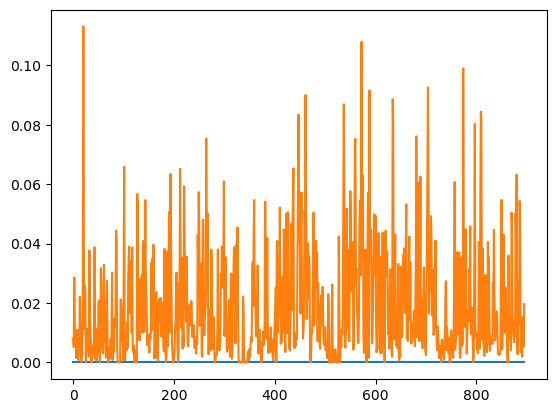

In [18]:
#ok let's plot it
import matplotlib.pyplot as plt
plt.plot(x[0,:,0].cpu().numpy())
plt.plot(y[:,0].cpu().numpy())

In [19]:
x

tensor([[[8.6377e-11],
         [8.6408e-11],
         [8.6580e-11],
         [8.6568e-11],
         [8.6431e-11],
         [8.6205e-11],
         [8.6864e-11],
         [8.8751e-11],
         [8.8103e-11],
         [8.6330e-11],
         [8.5266e-11],
         [8.5364e-11],
         [8.5827e-11],
         [8.5747e-11],
         [8.5175e-11],
         [8.4835e-11],
         [8.4827e-11],
         [8.5133e-11],
         [8.4976e-11],
         [8.4795e-11],
         [8.5335e-11],
         [8.5231e-11],
         [8.4847e-11],
         [8.4271e-11],
         [8.4478e-11],
         [8.4581e-11],
         [8.4564e-11],
         [8.4588e-11],
         [8.4728e-11],
         [8.4974e-11],
         [8.5115e-11],
         [8.5023e-11],
         [8.4713e-11],
         [8.4420e-11],
         [8.4287e-11],
         [8.4247e-11],
         [8.4303e-11],
         [8.4343e-11],
         [8.4355e-11],
         [8.4442e-11],
         [8.4490e-11],
         [8.4454e-11],
         [8.4214e-11],
         [8

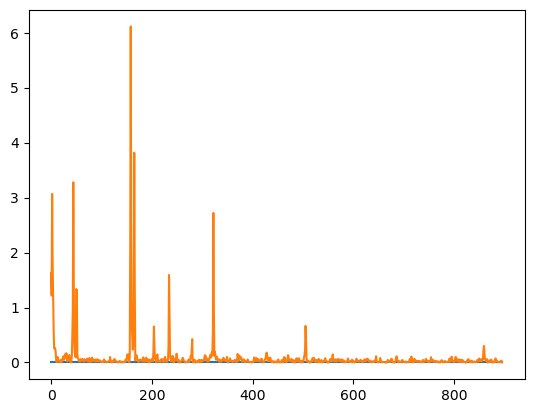

In [20]:
#let's try a different value that is not all near 0
x,y = dataset[1]
x = x.unsqueeze(0).to(device)
with torch.no_grad():
    x,_ = encoder(x)
    x,_ = backbone(x, skip_embedding=True)
    x = decoder(x)
plt.plot(x[0,:,0].cpu().numpy())
plt.plot(y[:,0].cpu().numpy())

In [21]:
x
#all values near 0... uhhhhhhh
#it seems that the softplus

tensor([[[2.5122e-10],
         [7.7093e-10],
         [8.0323e-10],
         [1.9162e-10],
         [1.0938e-10],
         [1.0137e-10],
         [8.9169e-11],
         [8.6182e-11],
         [8.6339e-11],
         [8.8184e-11],
         [9.5635e-11],
         [9.6327e-11],
         [8.7186e-11],
         [8.5979e-11],
         [8.8747e-11],
         [8.9150e-11],
         [8.6124e-11],
         [8.5339e-11],
         [8.5272e-11],
         [8.5030e-11],
         [8.5060e-11],
         [8.5174e-11],
         [8.5085e-11],
         [8.4635e-11],
         [8.4407e-11],
         [8.4542e-11],
         [8.4413e-11],
         [8.4323e-11],
         [8.4311e-11],
         [8.4419e-11],
         [8.4442e-11],
         [8.4272e-11],
         [8.4077e-11],
         [8.4130e-11],
         [8.4551e-11],
         [8.4811e-11],
         [8.4400e-11],
         [8.3877e-11],
         [8.3853e-11],
         [8.3894e-11],
         [8.3943e-11],
         [8.3848e-11],
         [8.3858e-11],
         [8

In [25]:
#calculate opisson loss
import torch.nn.functional as F
loss = F.poisson_nll_loss(x, y.to(device), log_input=False, full=False, eps=1e-8) #if we say log input is false then get a loss that isn't just 1, since we did softplus activation at the output, treat it like actual coutns output
print(loss)

tensor(1.6139, device='cuda:0')


# Now comparing models

In [ ]:
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
import src.dataloaders.datasets.enformer_dataset as enformer_dataset

#these are the only things we modify
dataset = enformer_dataset.EnformerDataset('test', 131_072, rc_aug = False, load_into_memory=False, cell_type=121)

In [28]:
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-07-27/00-44-43-866727/checkpoints/182-val_loss=0.13755.ckpt'
import yaml
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/enformer.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

model_cfg['layer']['l_max'] = 1026

# d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
# print(d_output, model_cfg, train_cfg)
d_output = 1
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.tasks.decoders import EnformerDecoder
from src.tasks.encoders import EnformerEncoder
import torch
backbone = DNAEmbeddingModel(**model_cfg)
decoder = EnformerDecoder(256, l_output=0, mode='pool', d_output=d_output, convolutions=False, downsampled=128)
encoder = EnformerEncoder(d_model = 256, pool_type='attention', conv_tower=True)
state_dict = torch.load(ckpt_path, map_location='cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
model_state_dict.keys()
for key in list(model_state_dict.keys()):
    if 'output_transform' in key:
        print(key)
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "decoder" in key:
        decoder_state_dict[key[10:]] = model_state_dict.pop(key)
encoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "encoder" in key:
        encoder_state_dict[key[10:]] = model_state_dict.pop(key)

encoder.load_state_dict(encoder_state_dict, strict=True)
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
encoder = encoder.to(device).eval()
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

decoder.0.output_transform.weight
decoder.0.output_transform.bias


In [29]:
import numpy as np
def pearsonr2(x, y):
    # Compute Pearson correlation coefficient. We can't use `cov` or `corrcoef`
    # because they want to compute everything pairwise between rows of a
    # stacked x and y.
    xm = x.mean(axis=-1, keepdims=True)
    ym = y.mean(axis=-1, keepdims=True)
    cov = np.sum((x - xm) * (y - ym), axis=-1)/(x.shape[-1]-1)
    sx = np.std(x, ddof=1, axis=-1)
    sy = np.std(y, ddof=1, axis=-1)
    rho = cov/(sx * sy)

    return rho

In [32]:
from tqdm import tqdm
corrs = np.zeros((len(dataset), dataset.d_output))
true_out = np.zeros((len(dataset), 896))
model_out = np.zeros((len(dataset), 896))
#and do the correlation for the other direction
for i in tqdm(range(len(dataset)), total=len(dataset)):
    x,y = dataset[i]
    with torch.no_grad():
        x = x.unsqueeze(0).to(device)
        x,_ = encoder(x)
        out1,_ = backbone(x, skip_embedding=True)
        out2 = decoder(out1)
        out2 = out2.cpu().detach().squeeze(0).numpy()
    corrs[i,:] = pearsonr2(out2.T, y.numpy().T)
    true_out[i,:] = y.numpy().squeeze()
    model_out[i,:] = out2.squeeze()

100%|██████████| 1937/1937 [00:26<00:00, 73.66it/s]


In [33]:
pearsonr2(out2.T, y.numpy().T) #output should be a single number since we only predict one track, just correlate with the whole track

array([0.38836163], dtype=float32)

In [34]:
# now save this out
np.save('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_convtower_corrs.npy', corrs)
np.save('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_convtower_true_out.npy', true_out)
np.save('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_convtower_model_out.npy', model_out)

# now no conv tower

In [35]:
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-07-27/00-44-59-341694/checkpoints/20-val_loss=0.15961.ckpt'
import yaml
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/enformer.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

model_cfg['layer']['l_max'] = 65536+2 #this is wrong but what I used accidentally...

# d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
# print(d_output, model_cfg, train_cfg)
d_output = 1
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.tasks.decoders import EnformerDecoder
from src.tasks.encoders import EnformerEncoder
import torch
backbone = DNAEmbeddingModel(**model_cfg)
decoder = EnformerDecoder(256, l_output=0, mode='pool', d_output=d_output, convolutions=False, downsampled=2)
encoder = EnformerEncoder(d_model = 256, pool_type='attention', conv_tower=False, )
state_dict = torch.load(ckpt_path, map_location='cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
model_state_dict.keys()
for key in list(model_state_dict.keys()):
    if 'output_transform' in key:
        print(key)
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "decoder" in key:
        decoder_state_dict[key[10:]] = model_state_dict.pop(key)
encoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "encoder" in key:
        encoder_state_dict[key[10:]] = model_state_dict.pop(key)

encoder.load_state_dict(encoder_state_dict, strict=True)
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
encoder = encoder.to(device).eval()
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

decoder.0.output_transform.weight
decoder.0.output_transform.bias


In [36]:
from tqdm import tqdm
corrs = np.zeros((len(dataset), dataset.d_output))
true_out = np.zeros((len(dataset), 896))
model_out = np.zeros((len(dataset), 896))
#and do the correlation for the other direction
for i in tqdm(range(len(dataset)), total=len(dataset)):
    x,y = dataset[i]
    with torch.no_grad():
        x = x.unsqueeze(0).to(device)
        x,_ = encoder(x)
        out1,_ = backbone(x, skip_embedding=True)
        out2 = decoder(out1)
        out2 = out2.cpu().detach().squeeze(0).numpy()
    corrs[i,:] = pearsonr2(out2.T, y.numpy().T)
    true_out[i,:] = y.numpy().squeeze()
    model_out[i,:] = out2.squeeze()

100%|██████████| 1937/1937 [07:16<00:00,  4.44it/s]


In [37]:
print(pearsonr2(out2.T, y.numpy().T)) #output should be a single number since we only predict one track, just correlate with the whole track
# now save this out
np.save('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_noconvtower_corrs.npy', corrs)
np.save('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_noconvtower_true_out.npy', true_out)
np.save('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_noconvtower_model_out.npy', model_out)

[0.4173527]


In [38]:
#and final sanity chjeck to make sure the true outs are the sasme
np.allclose(np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_noconvtower_true_out.npy'), np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_convtower_true_out.npy'))

True

# and evaluating the traditional hyena models

In [41]:
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-07-23/13-02-07-155779/checkpoints/06-val_loss=0.16521.ckpt'
import yaml
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/enformer.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

model_cfg['layer']['l_max'] = 160000+2 #this is wrong but what I used accidentally...

# d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
# print(d_output, model_cfg, train_cfg)
d_output = 1
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.tasks.decoders import EnformerDecoder
# from src.tasks.encoders import EnformerEncoder
import torch
backbone = DNAEmbeddingModel(**model_cfg)
decoder = EnformerDecoder(256, l_output=0, mode='pool', d_output=d_output, convolutions=False)
# encoder = EnformerEncoder(d_model = 256, pool_type='attention', conv_tower=False, )
state_dict = torch.load(ckpt_path, map_location='cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
model_state_dict.keys()
for key in list(model_state_dict.keys()):
    if 'output_transform' in key:
        print(key)
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "decoder" in key:
        decoder_state_dict[key[10:]] = model_state_dict.pop(key)
encoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "encoder" in key:
        encoder_state_dict[key[10:]] = model_state_dict.pop(key)

# encoder.load_state_dict(encoder_state_dict, strict=True)
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
# encoder = encoder.to(device).eval()
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

decoder.0.output_transform.weight
decoder.0.output_transform.bias


In [43]:
from tqdm import tqdm
corrs = np.zeros((len(dataset), dataset.d_output))
true_out = np.zeros((len(dataset), 896))
model_out = np.zeros((len(dataset), 896))
#and do the correlation for the other direction
for i in tqdm(range(len(dataset)), total=len(dataset)):
    x,y = dataset[i]
    with torch.no_grad():
        x = x.unsqueeze(0).to(device)
        # x,_ = encoder(x)
        out1,_ = backbone(x)
        out2 = decoder(out1)
        out2 = out2.cpu().detach().squeeze(0).numpy()
    corrs[i,:] = pearsonr2(out2.T, y.numpy().T)
    true_out[i,:] = y.numpy().squeeze()
    model_out[i,:] = out2.squeeze()

100%|██████████| 1937/1937 [15:47<00:00,  2.05it/s]


In [44]:
print(pearsonr2(out2.T, y.numpy().T)) #output should be a single number since we only predict one track, just correlate with the whole track
# now save this out
np.save('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_corrs.npy', corrs)
np.save('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_true_out.npy', true_out)
np.save('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_model_out.npy', model_out)

[0.33444288]


# actual enformer model

In [1]:
batch_size = 8
channels = 1536
num_elem = 1937 #how many train samples

#now simply retest it by running it all again!
import json
import functools
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import numpy as np
import h5py
import tensorflow as tf
import sonnet as snt
from IPython.display import clear_output
import time
import sys
sys.path.append('/data/leslie/sarthak/data/enformer')
import enformer


def organism_path(organism):
  return os.path.join('/data/leslie/sarthak/data/enformer/data/', organism) #just leads to the organism path, quite easy


def get_dataset(organism, subset, num_threads=4): #this gets the data and deserializes it
  metadata = get_metadata(organism)
  dataset = tf.data.TFRecordDataset(tfrecord_files(organism, subset),
                                    compression_type='ZLIB',
                                    num_parallel_reads=num_threads)
  dataset = dataset.map(functools.partial(deserialize, metadata=metadata),
                        num_parallel_calls=num_threads)
  return dataset


def get_metadata(organism):
  # Keys:
  # num_targets, train_seqs, valid_seqs, test_seqs, seq_length,
  # pool_width, crop_bp, target_length
  path = os.path.join(organism_path(organism), 'statistics.json')
  with tf.io.gfile.GFile(path, 'r') as f:
    return json.load(f)


def tfrecord_files(organism, subset): #this is the function that gets the TFR files, gets all of them and sorts them
  # Sort the values by int(*).
  return sorted(tf.io.gfile.glob(os.path.join(
      organism_path(organism), 'tfrecords', f'{subset}-*.tfr'
  )), key=lambda x: int(x.split('-')[-1].split('.')[0]))


def deserialize(serialized_example, metadata):
  """Deserialize bytes stored in TFRecordFile."""
  feature_map = {
      'sequence': tf.io.FixedLenFeature([], tf.string),
      'target': tf.io.FixedLenFeature([], tf.string),
  }
  example = tf.io.parse_example(serialized_example, feature_map)
  sequence = tf.io.decode_raw(example['sequence'], tf.bool)
  sequence = tf.reshape(sequence, (metadata['seq_length'], 4))
  sequence = tf.cast(sequence, tf.float32)

  target = tf.io.decode_raw(example['target'], tf.float16)
  target = tf.reshape(target,
                      (metadata['target_length'], metadata['num_targets']))
  target = tf.cast(target, tf.float32)

  return {'sequence': sequence,
          'target': target}

def get_targets(organism):
  targets_txt = f'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_{organism}.txt'
  return pd.read_csv(targets_txt, sep='\t')
df_targets_human = get_targets('human')
# df_targets_human.head()

human_dataset = get_dataset('human', 'test')

learning_rate = tf.Variable(0., trainable=False, name='learning_rate')
optimizer = snt.optimizers.Adam(learning_rate=learning_rate) #updated each step, if just do 1 step it's 0

model = enformer.Enformer(channels=channels,  # Use 4x fewer channels to train faster.
                          num_heads=8,
                          num_transformer_layers=11,
                          pooling_type='max',
                          d_output=1)


ckpt_path = '/data/leslie/sarthak/data/enformer/model_checkpoints/'
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
#and load checkpoint
checkpoint.restore('/data/leslie/sarthak/data/enformer/model_checkpoints/ckpt_loss=0.1894436478614807-epoch=4-5')


2024-07-28 23:40:59.352089: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-07-28 23:41:17.334778: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-07-28 23:41:17.710153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.35GiB deviceMemoryBandwidth: 648.29GiB/s
2024-07-28 23:41:17.713565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.35GiB deviceMemoryBandwidth: 648.29GiB/s
2024-07-28 23:41:17.715643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:ca:00.0 name: NVIDIA A40 com

In [5]:
#let's get a batch of data
batch = next(iter(human_dataset.batch(batch_size)))
print(batch['sequence'].shape)
print(batch['target'].shape)

(8, 131072, 4)
(8, 896, 5313)


In [7]:
#now let's get one output of the model
output = model(batch['sequence'], is_training=False)['human']
print(output.shape)

2024-07-28 23:42:51.544745: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-07-28 23:42:51.754013: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8907
2024-07-28 23:42:52.789809: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-07-28 23:42:54.954761: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-07-28 23:42:55.151178: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(8, 896, 1)


In [9]:
outputs = np.zeros((num_elem, 896))
true_outs = np.zeros((num_elem, 896))
dataset_train = human_dataset.batch(batch_size)
i = 0
for batch_human in tqdm(dataset_train, total = num_elem // batch_size):
    outputs_human = model(batch_human['sequence'], is_training=True)['human']
    outputs[i:i+batch_size,:] = outputs_human.numpy()[:,:,0]
    true_outs[i:i+batch_size,:] = batch_human['target'].numpy()[:,:,121]
    i = i + batch_size

  0%|          | 0/242 [00:00<?, ?it/s]

243it [04:28,  1.11s/it]                         


In [10]:
#let's load in the other true outputs and compare them
true_outs_hyena = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_true_out.npy')
np.allclose(true_outs_hyena, true_outs)

True

In [12]:
#go through and calculate the correlations

def pearsonr2(x, y):
    # Compute Pearson correlation coefficient. We can't use `cov` or `corrcoef`
    # because they want to compute everything pairwise between rows of a
    # stacked x and y.
    xm = x.mean(axis=-1, keepdims=True)
    ym = y.mean(axis=-1, keepdims=True)
    cov = np.sum((x - xm) * (y - ym), axis=-1)/(x.shape[-1]-1)
    sx = np.std(x, ddof=1, axis=-1)
    sy = np.std(y, ddof=1, axis=-1)
    rho = cov/(sx * sy)

    return rho

corr = pearsonr2(outputs, true_outs)
print(corr.shape)

(1937,)


In [13]:
#save it all out
np.save('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_human_corrs.npy', corr)
np.save('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_human_true_out.npy', true_outs)
np.save('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_human_model_out.npy', outputs)

# and now let's compare the model outputs and plot an example

In [1]:
# so first load in the data
import numpy as np
corrs_enformer = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_human_corrs.npy')
corrs_hyena = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_corrs.npy')
corrs_hyena_cnn_convtower = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_convtower_corrs.npy')
corrs_hyena_cnn_noconvtower = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_noconvtower_corrs.npy')
#print shapes
print(corrs_enformer.shape, corrs_hyena.shape, corrs_hyena_cnn_convtower.shape, corrs_hyena_cnn_noconvtower.shape)

(1937,) (1937, 1) (1937, 1) (1937, 1)


Text(0.5, 1.0, 'Enformer vs Hyena Correlations')

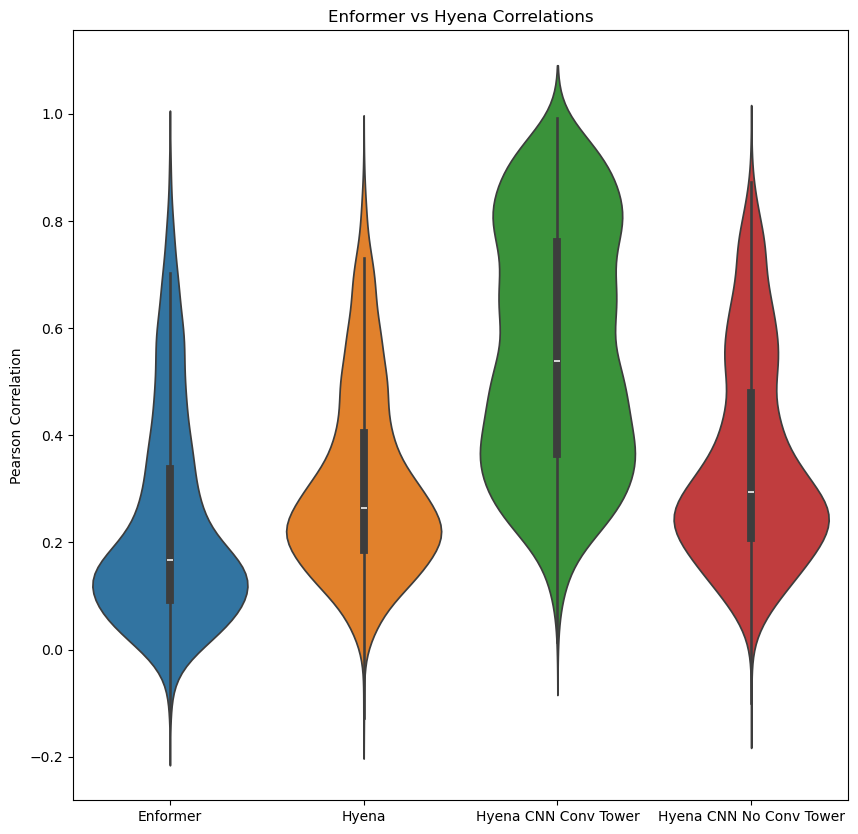

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
#and now do a violin plot of the correlations
plt.figure(figsize=(10,10))
sns.violinplot(data=[corrs_enformer.flatten(), corrs_hyena.flatten(), corrs_hyena_cnn_convtower.flatten(), corrs_hyena_cnn_noconvtower.flatten()])
plt.xticks([0,1,2,3], ['Enformer', 'Hyena', 'Hyena CNN Conv Tower', 'Hyena CNN No Conv Tower'])
plt.ylabel('Pearson Correlation')
plt.title('Enformer vs Hyena Correlations')

In [46]:
#let's test this by looking at a sample output
#load in the true and the model outputs
true_out = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_human_true_out.npy')
enformer_out = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_human_model_out.npy')
hyena_out = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_model_out.npy')
hyena_cnn_convtower_out = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_convtower_model_out.npy')
hyena_cnn_noconvtower_out = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_noconvtower_model_out.npy')
#print all the shapes
print(true_out.shape, enformer_out.shape, hyena_out.shape, hyena_cnn_convtower_out.shape, hyena_cnn_noconvtower_out.shape)

(1937, 896) (1937, 896) (1937, 896) (1937, 896) (1937, 896)


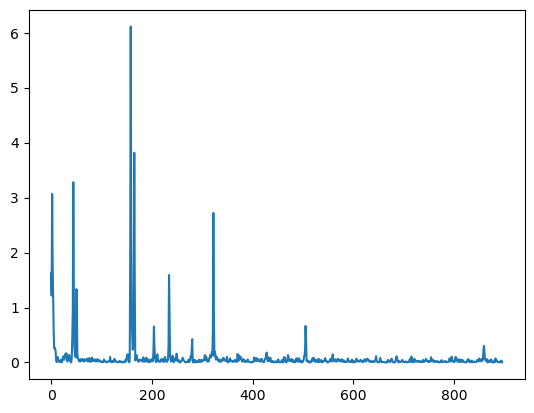

In [5]:
#let's look at an example
idx = 1
plt.plot(true_out[idx,:])

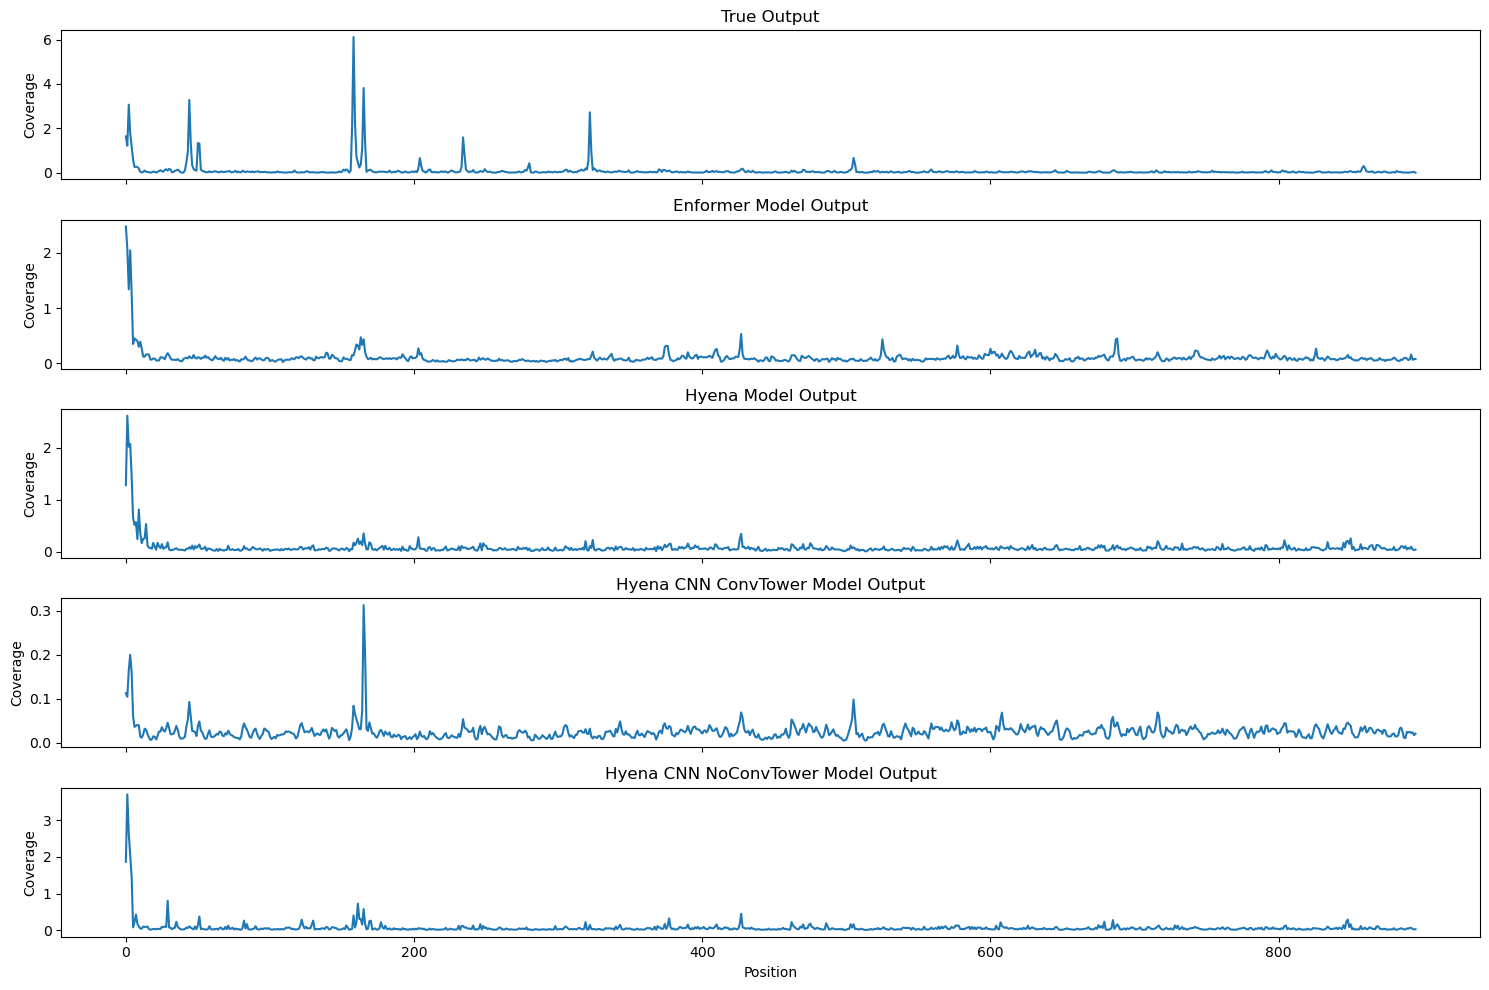

In [47]:
def plot_genome_coverage(index):
    # Extract the row for the given index from each dataset
    true_values = true_out[index]
    enformer_values = enformer_out[index]
    hyena_values = hyena_out[index]
    hyena_cnn_convtower_values = hyena_cnn_convtower_out[index]
    hyena_cnn_noconvtower_values = hyena_cnn_noconvtower_out[index]
    
    # Create subplots
    fig, axs = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
    
    # Plot each set of values on a separate subplot
    axs[0].plot(true_values)
    axs[0].set_title('True Output')
    axs[1].plot(enformer_values)
    axs[1].set_title('Enformer Model Output')
    axs[2].plot(hyena_values)
    axs[2].set_title('Hyena Model Output')
    axs[3].plot(hyena_cnn_convtower_values)
    axs[3].set_title('Hyena CNN ConvTower Model Output')
    axs[4].plot(hyena_cnn_noconvtower_values)
    axs[4].set_title('Hyena CNN NoConvTower Model Output')
    
    # Set labels and titles
    for ax in axs:
        ax.set_ylabel('Coverage')
    axs[-1].set_xlabel('Position')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage
plot_genome_coverage(1)  # Replace 0 with the desired index

In [48]:
#let's calculate a quick correlation
from scipy.stats import pearsonr
print(pearsonr(true_out[idx,:], hyena_cnn_convtower_out[idx,:]))

PearsonRResult(statistic=0.9637373094284462, pvalue=0.0)


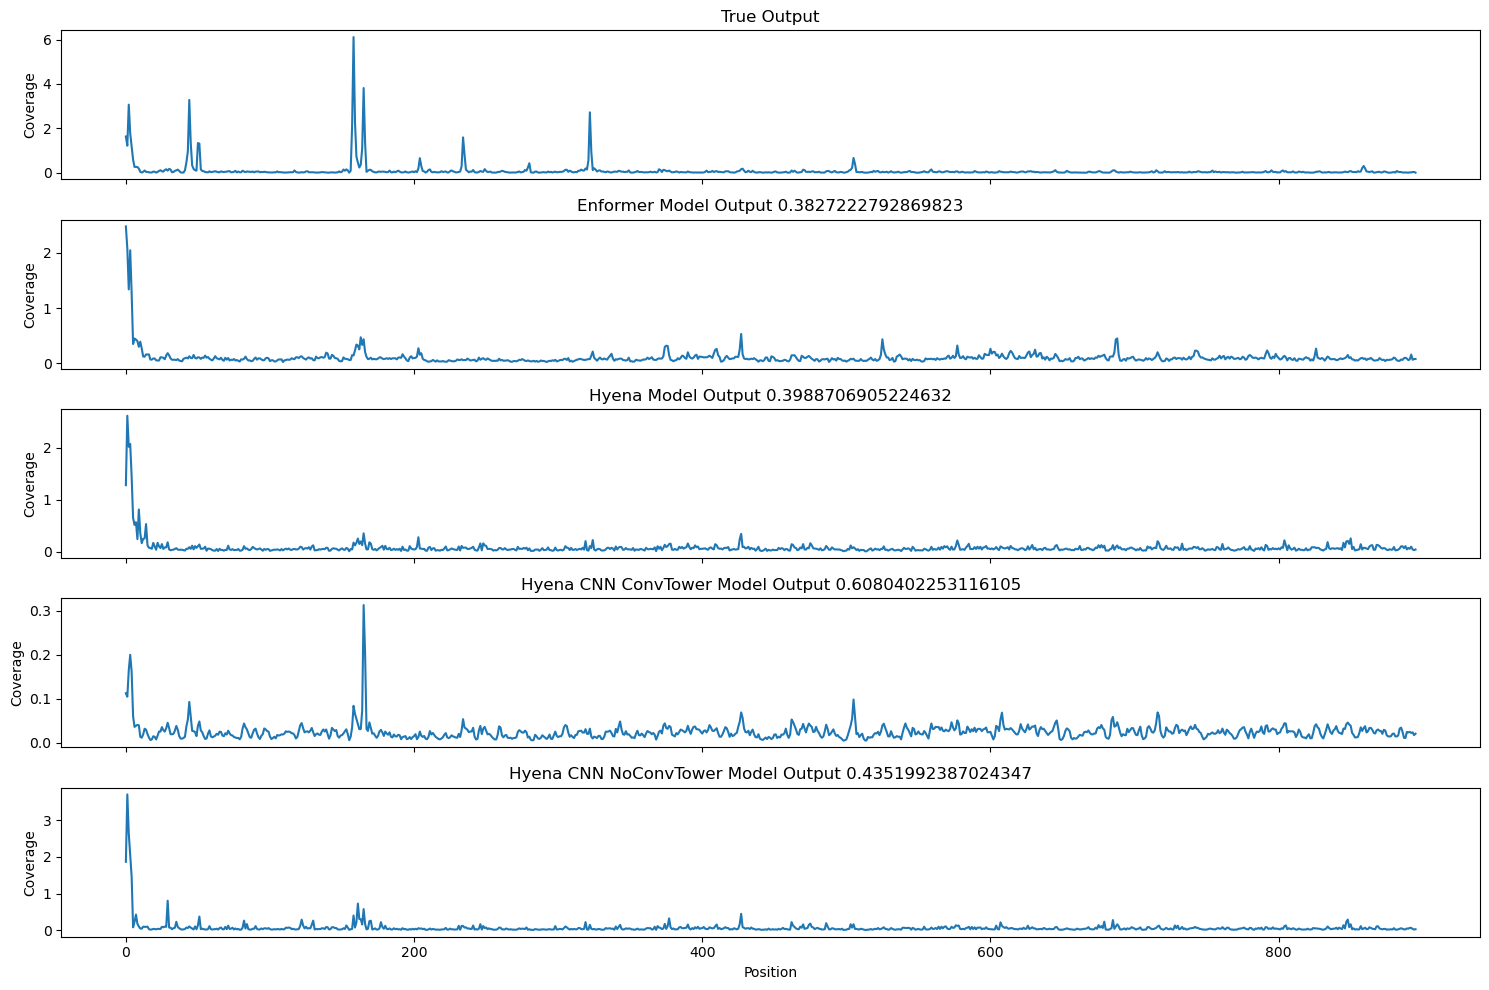

In [49]:
def plot_genome_coverage(index):
    # Extract the row for the given index from each dataset
    true_values = true_out[index]
    enformer_values = enformer_out[index]
    hyena_values = hyena_out[index]
    hyena_cnn_convtower_values = hyena_cnn_convtower_out[index]
    hyena_cnn_noconvtower_values = hyena_cnn_noconvtower_out[index]
    
    # Create subplots
    fig, axs = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
    
    # Plot each set of values on a separate subplot
    axs[0].plot(true_values)
    axs[0].set_title('True Output')
    axs[1].plot(enformer_values)
    axs[1].set_title('Enformer Model Output ' + str(pearsonr(true_values, enformer_values)[0]))
    axs[2].plot(hyena_values)
    axs[2].set_title('Hyena Model Output ' + str(pearsonr(true_values, hyena_values)[0]))
    axs[3].plot(hyena_cnn_convtower_values)
    axs[3].set_title('Hyena CNN ConvTower Model Output ' + str(pearsonr(true_values, hyena_cnn_convtower_values)[0]))
    axs[4].plot(hyena_cnn_noconvtower_values)
    axs[4].set_title('Hyena CNN NoConvTower Model Output ' + str(pearsonr(true_values, hyena_cnn_noconvtower_values)[0]))
    # Set labels and titles
    for ax in axs:
        ax.set_ylabel('Coverage')
    axs[-1].set_xlabel('Position')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage
plot_genome_coverage(1)  # Replace 0 with the desired index

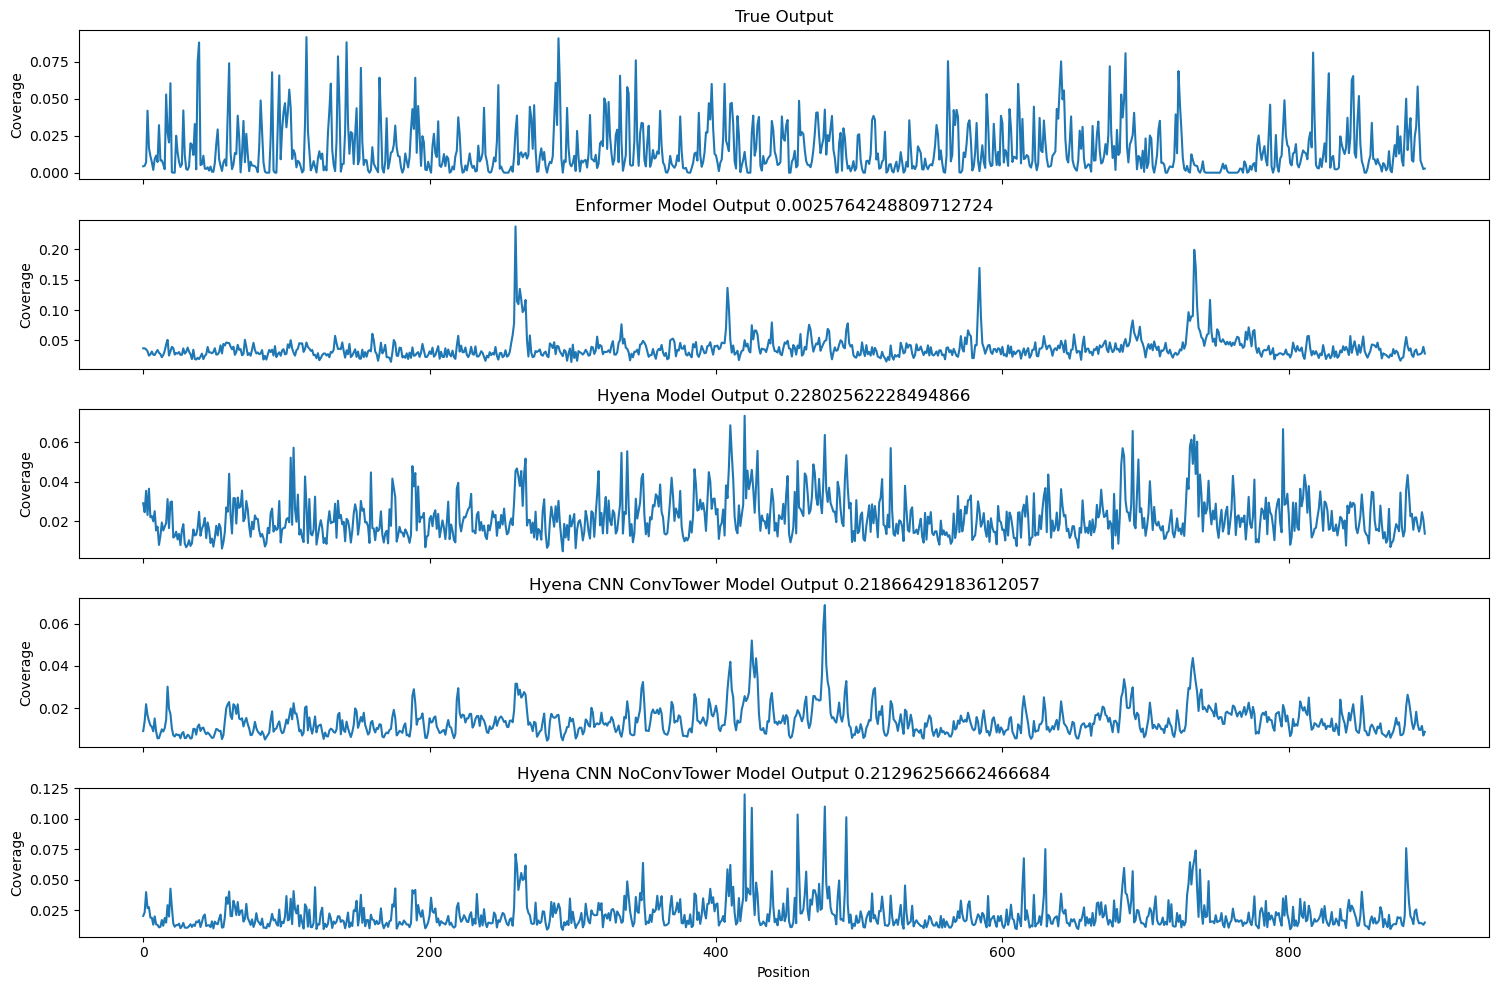

In [50]:
plot_genome_coverage(2)

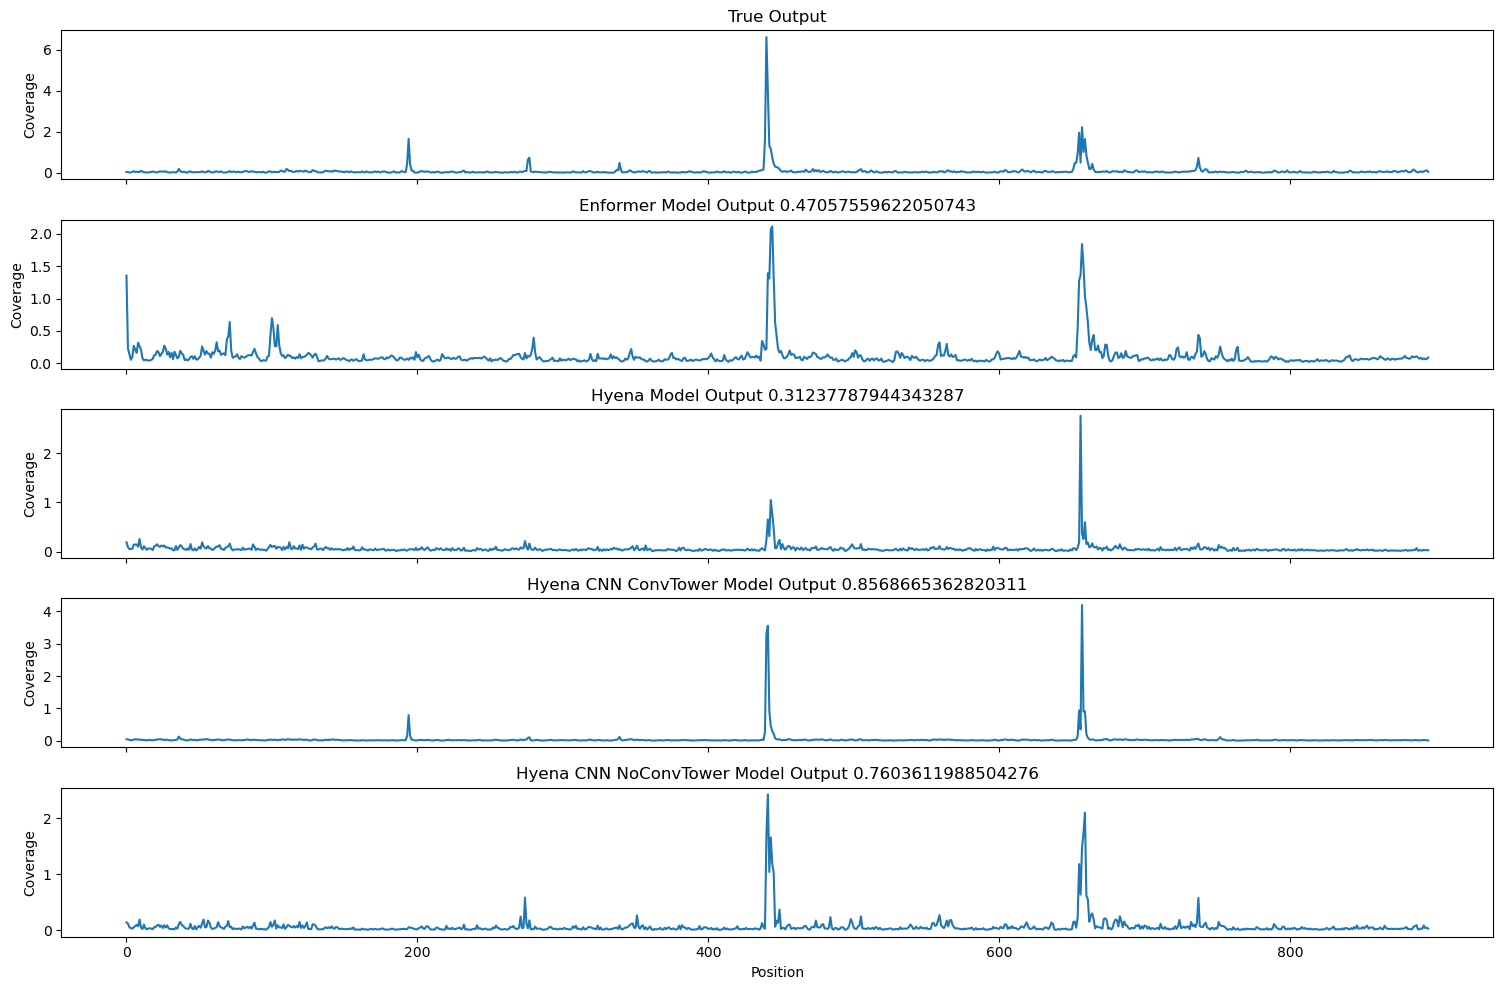

In [51]:
plot_genome_coverage(3)

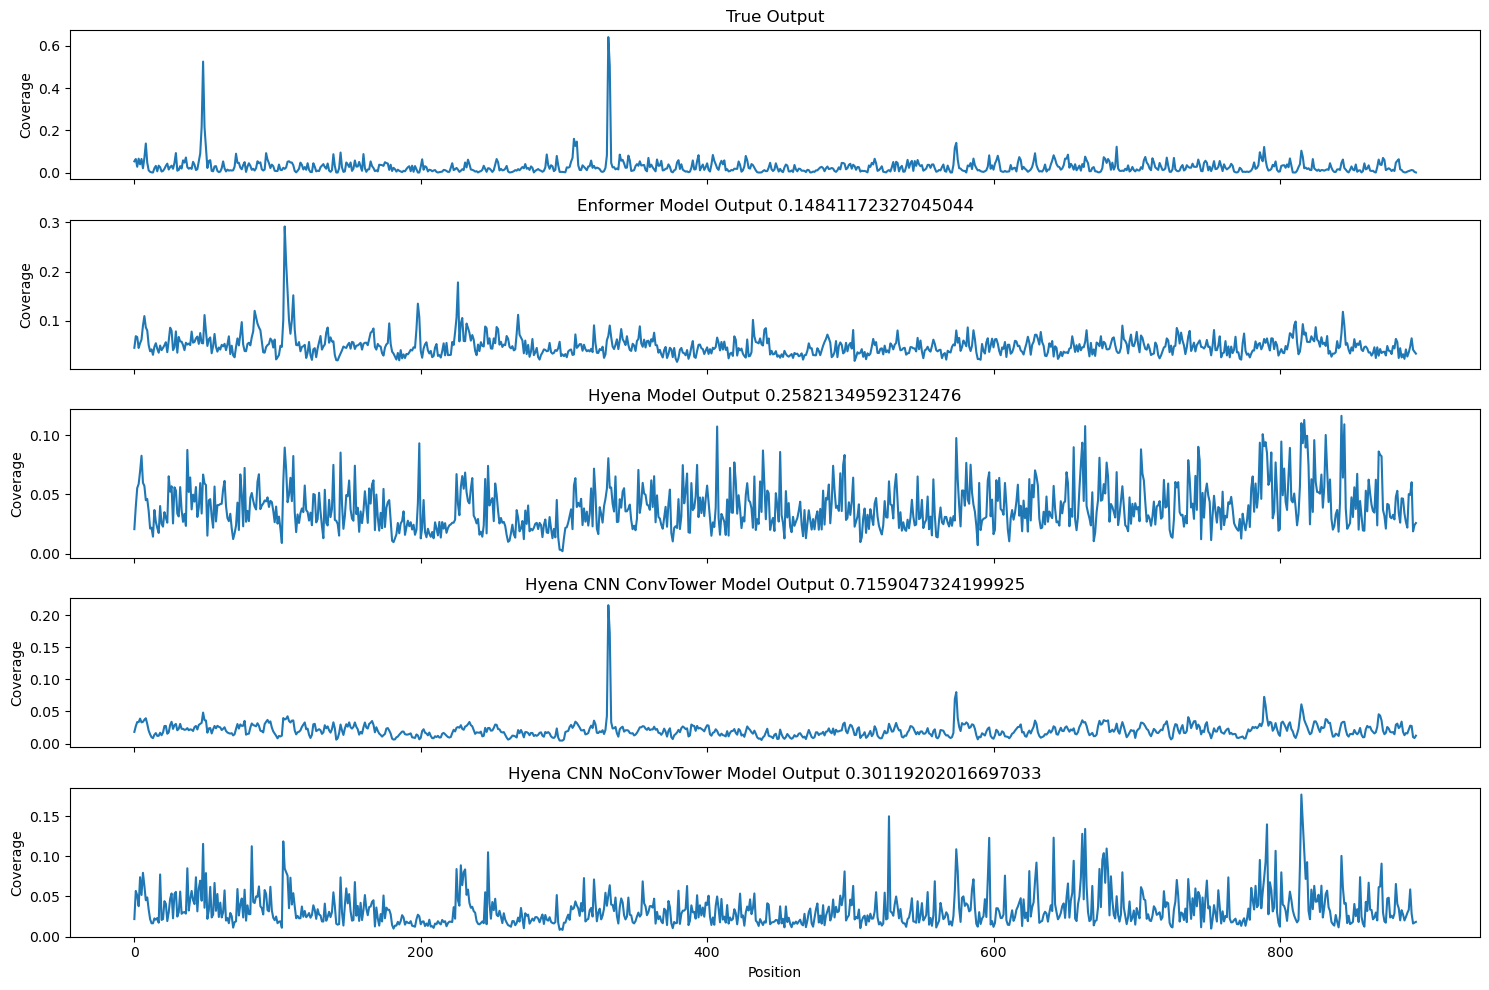

In [52]:
plot_genome_coverage(8)

In [12]:
#let's also plot the loss from enformer
#it was saved with this
# np.save('/data/leslie/sarthak/data/enformer/loss_array.npy', loss_array)
# np.save('/data/leslie/sarthak/data/enformer/val_loss_array.npy', val_loss_array)

loss = np.load('/data/leslie/sarthak/data/enformer/loss_array.npy')
val_loss = np.load('/data/leslie/sarthak/data/enformer/val_loss_array.npy')
print(loss.shape, val_loss.shape)

(5, 4253) (5, 139)


Text(0.5, 1.0, 'Enformer Training Loss')

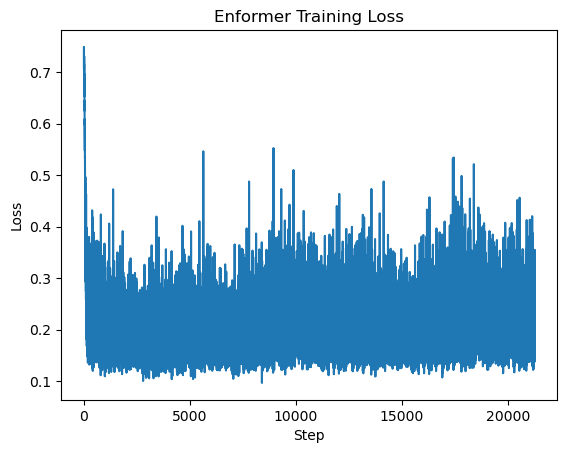

In [15]:
#5 for the 5 epochs
plt.plot(loss.flatten())
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Enformer Training Loss')

Text(0.5, 1.0, 'Enformer Validation Loss')

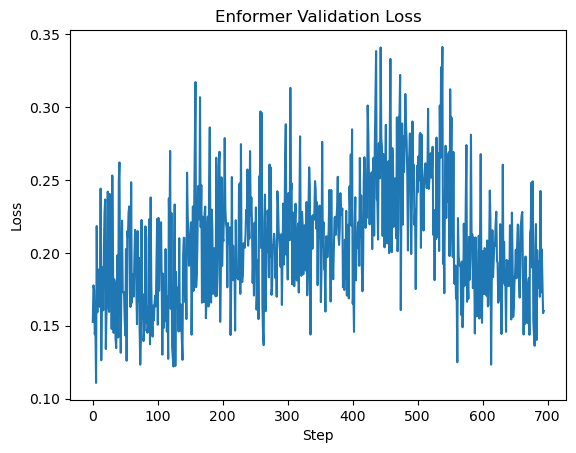

In [16]:
plt.plot(val_loss.flatten())
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Enformer Validation Loss')

0.9921773076057434


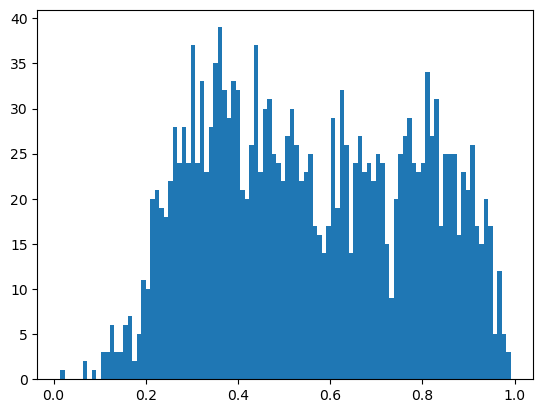

In [23]:
#and a hsitogram of the corrs_hyena_cnn_convtower.flatten()
plt.hist(corrs_hyena_cnn_convtower.flatten(), bins=100)
print(np.max(corrs_hyena_cnn_convtower.flatten())) #less than 1 is perfect

In [53]:
#let's also find an example where one is far above the others
a,b,c,d = corrs_enformer.flatten(), corrs_hyena.flatten(), corrs_hyena_cnn_convtower.flatten(), corrs_hyena_cnn_noconvtower.flatten()
#now go through all the values and find the one that has the highest difference with enformer
diffs = np.abs(a-b) + np.abs(a-c) + np.abs(a-d)
idx = np.argmax(diffs)
idx

1267

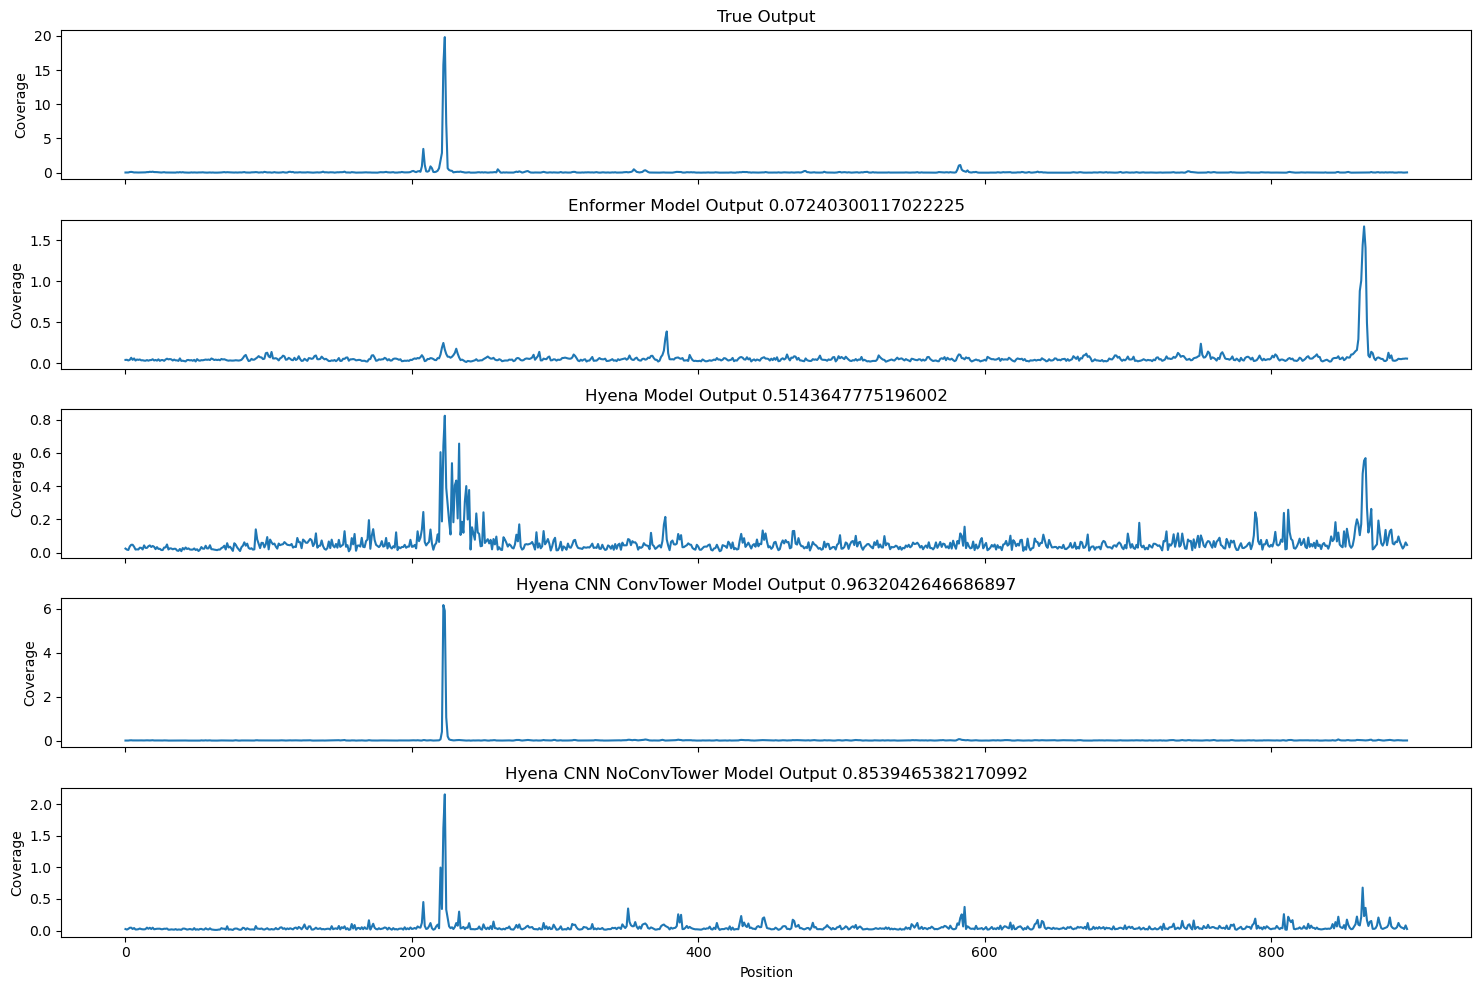

In [54]:
plot_genome_coverage(1267)

In [55]:
#and let's find one where enformer is the best
diffs = (a-b) + (a-c) + (a-d)
idx = np.argmax(diffs)
print(idx)

189


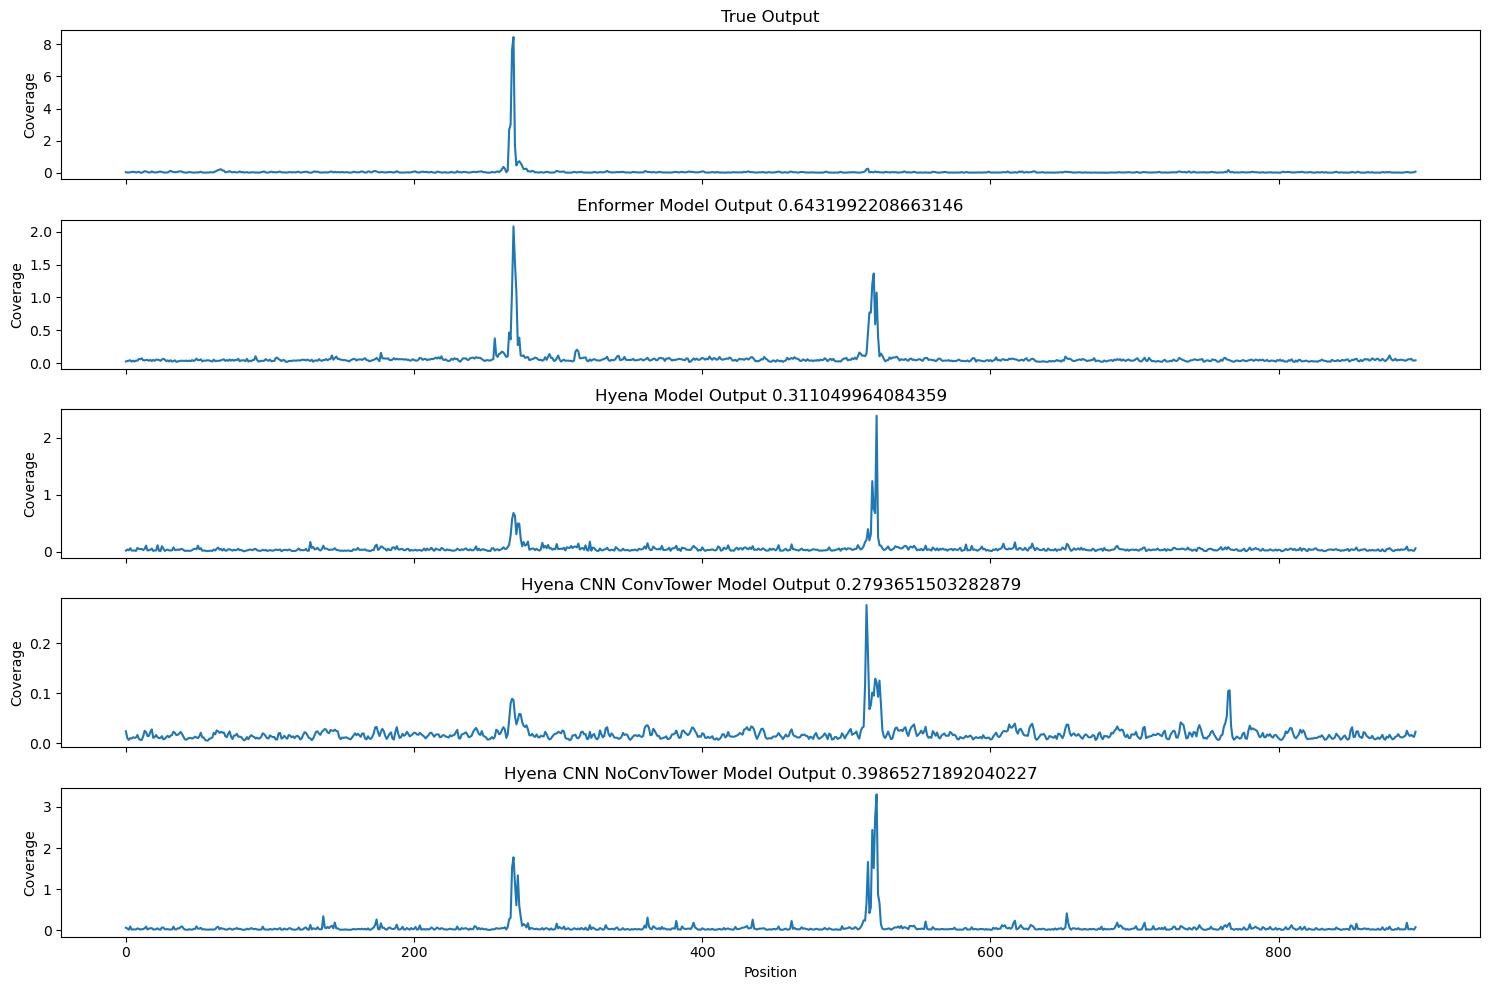

In [56]:
plot_genome_coverage(189)

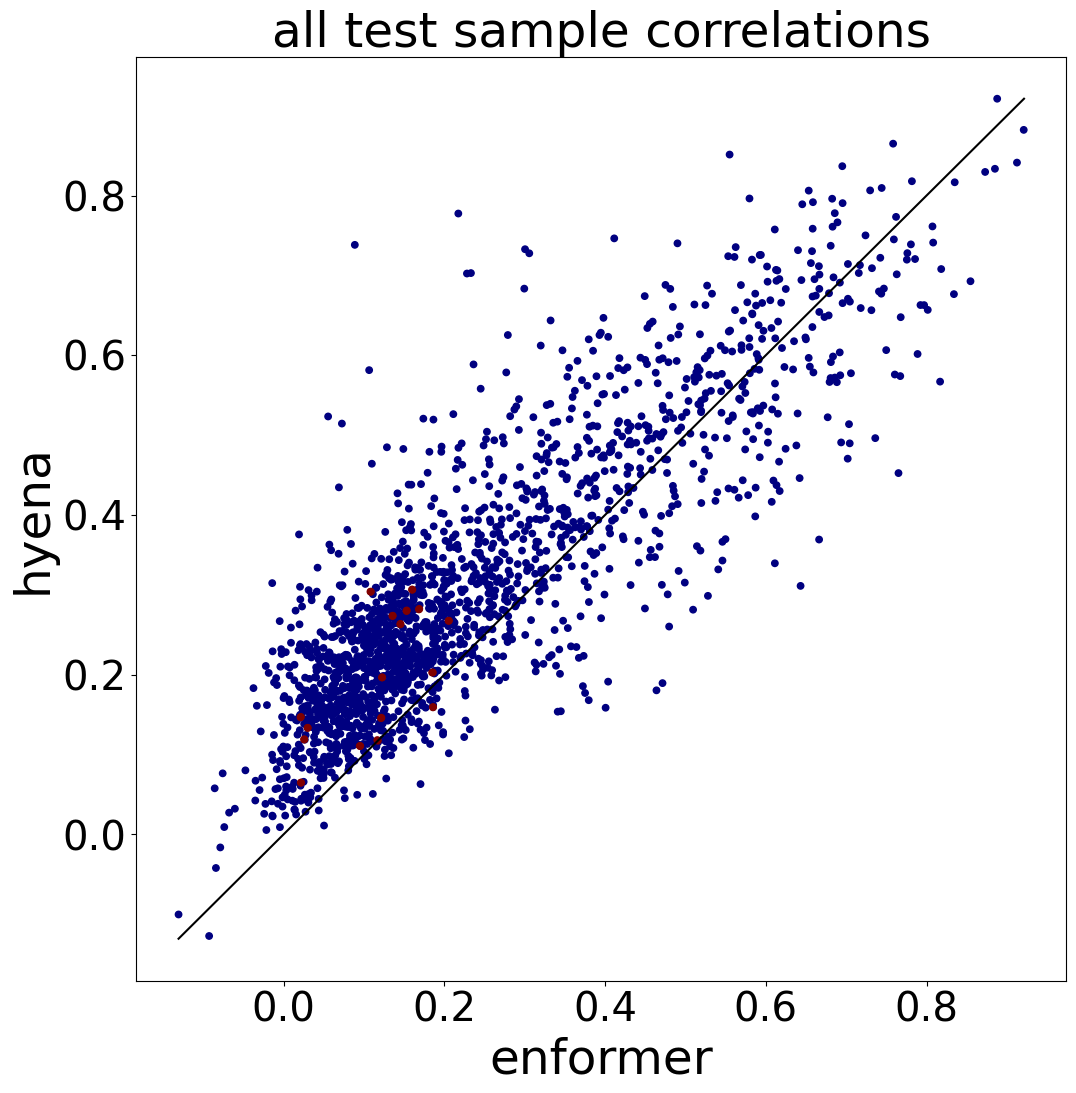

In [31]:
x,y = a, b
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(12,12)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.', s = 85)
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('enformer', fontsize=35)
plt.ylabel('hyena', fontsize=35)
plt.title('all test sample correlations', fontsize=35)
plt.tick_params(labelsize=29)

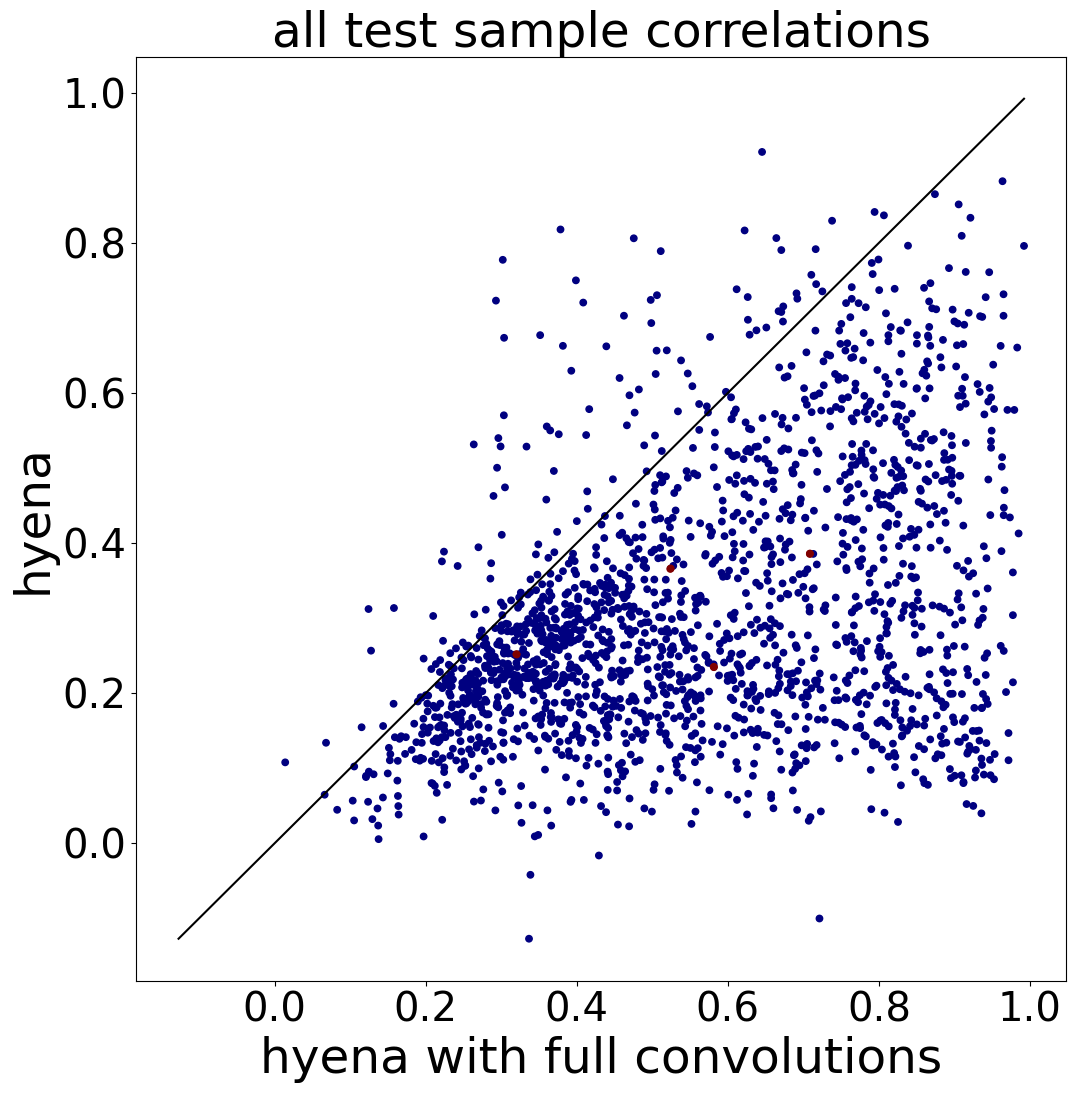

In [34]:
x,y = c, b
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(12,12)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.', s = 85)
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('hyena with full convolutions', fontsize=35)
plt.ylabel('hyena', fontsize=35)
plt.title('all test sample correlations', fontsize=35)
plt.tick_params(labelsize=29)

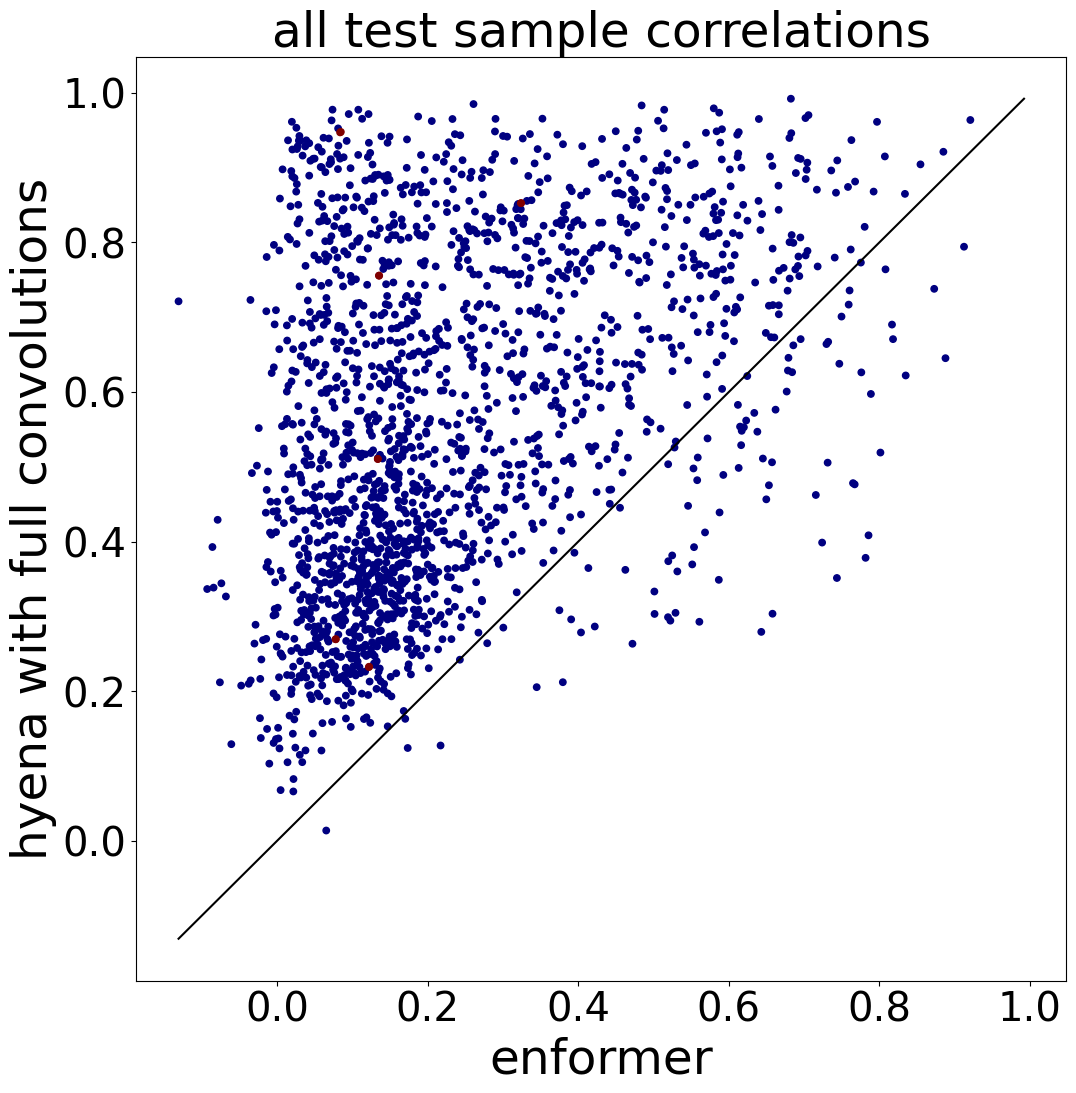

In [32]:
x,y = a, c
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(12,12)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.', s = 85)
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('enformer', fontsize=35)
plt.ylabel('hyena with full convolutions', fontsize=35)
plt.title('all test sample correlations', fontsize=35)
plt.tick_params(labelsize=29)

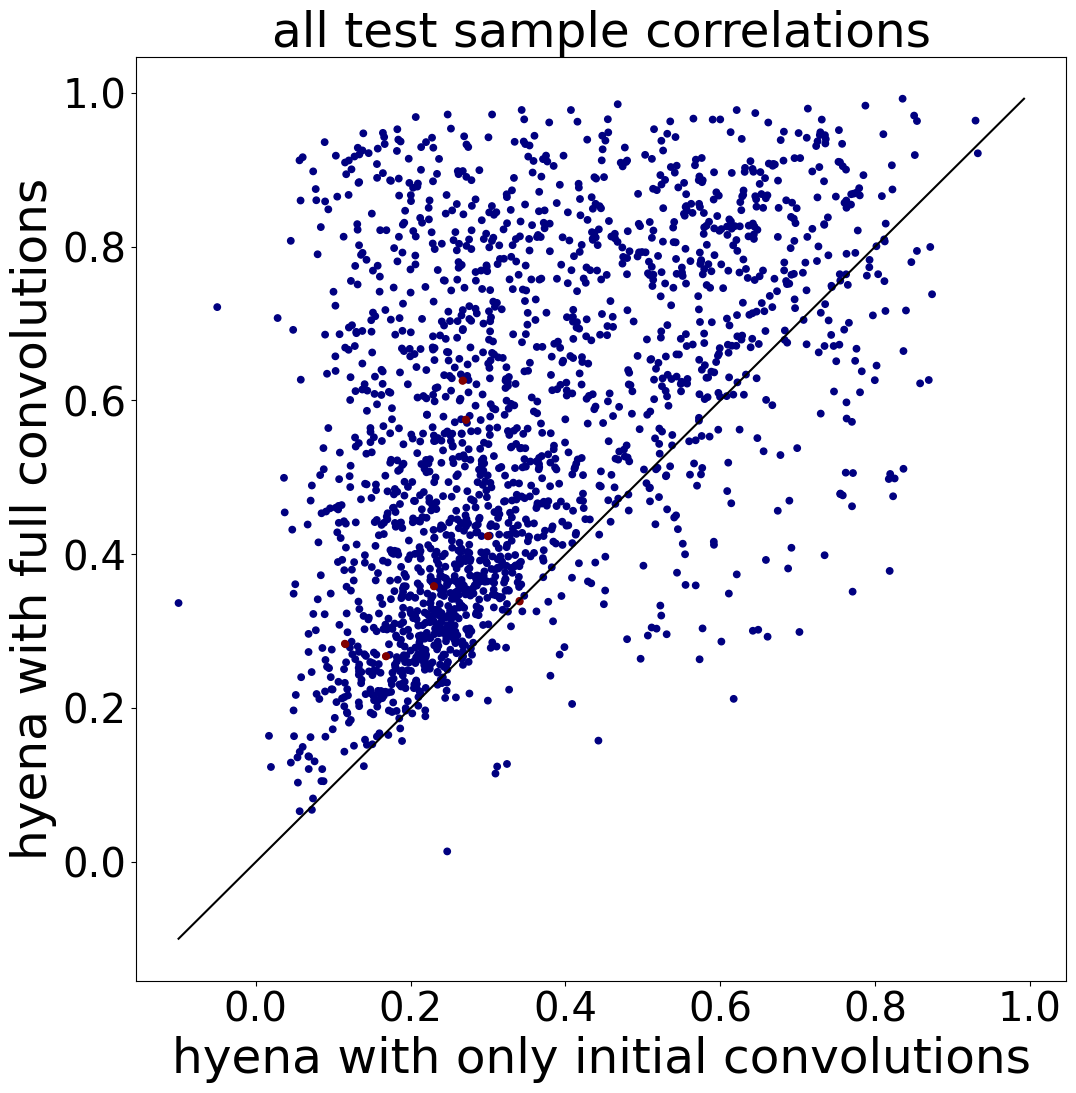

In [33]:
x,y = d, c
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(12,12)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.', s = 85)
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('hyena with only initial convolutions', fontsize=35)
plt.ylabel('hyena with full convolutions', fontsize=35)
plt.title('all test sample correlations', fontsize=35)
plt.tick_params(labelsize=29)

In [35]:
#find the one where a is the highest
idx = np.argmax(a)

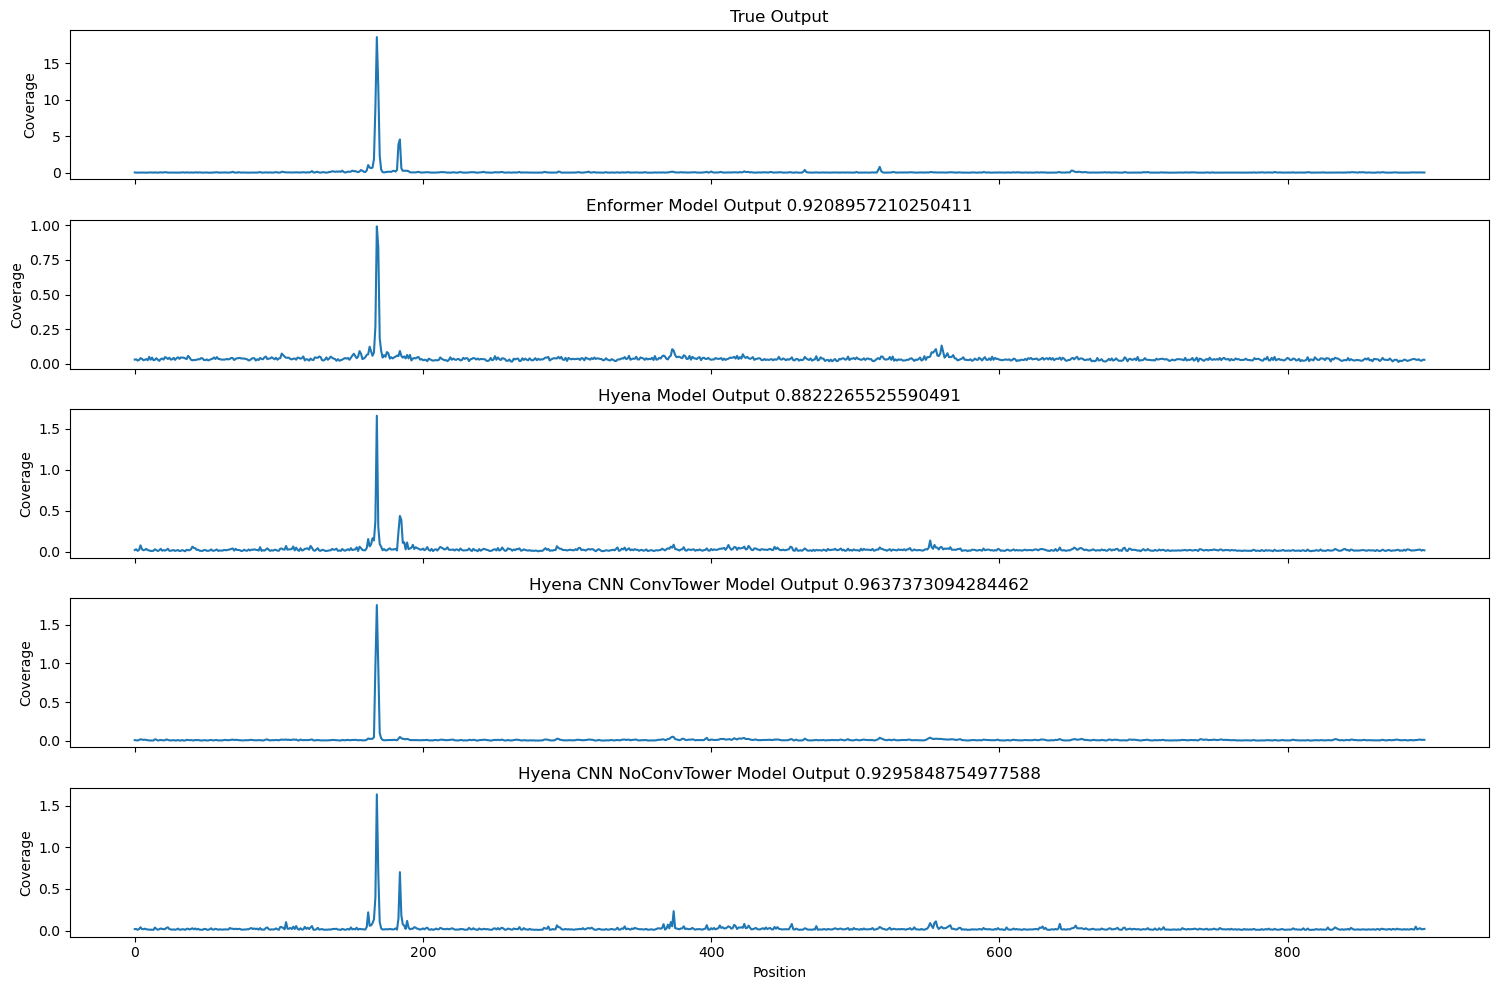

In [36]:
#and plot it
plot_genome_coverage(idx)

# wait we haven't been doing np.exp?

In [63]:
#Vladimir
true_out = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_human_true_out.npy')
enformer_out = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_human_model_out.npy')
hyena_out = np.exp(np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_model_out.npy'))
hyena_cnn_convtower_out = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_convtower_model_out.npy')
hyena_cnn_noconvtower_out = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_cnn_noconvtower_model_out.npy')

In [67]:
#now correlate it with true out
def pearsonr2(x, y):
    # Compute Pearson correlation coefficient. We can't use `cov` or `corrcoef`
    # because they want to compute everything pairwise between rows of a
    # stacked x and y.
    xm = x.mean(axis=-1, keepdims=True)
    ym = y.mean(axis=-1, keepdims=True)
    cov = np.sum((x - xm) * (y - ym), axis=-1)/(x.shape[-1]-1)
    sx = np.std(x, ddof=1, axis=-1)
    sy = np.std(y, ddof=1, axis=-1)
    rho = cov/(sx * sy)

    return rho

corrs_hyena = pearsonr2(hyena_out, true_out)
print(corrs_hyena.shape)

(1937,)


In [68]:
print(corrs_hyena.mean())

0.2955723225610357


In [62]:
#load the old one
corrs_hyena_old = np.load('/data/leslie/sarthak/hyena/hyena-dna/evals/enformer_hyena_corrs.npy')
print(corrs_hyena_old.mean())

0.30793665598349035


In [70]:
corrs_hyena_old.shape

(1937, 1)

<Axes: >

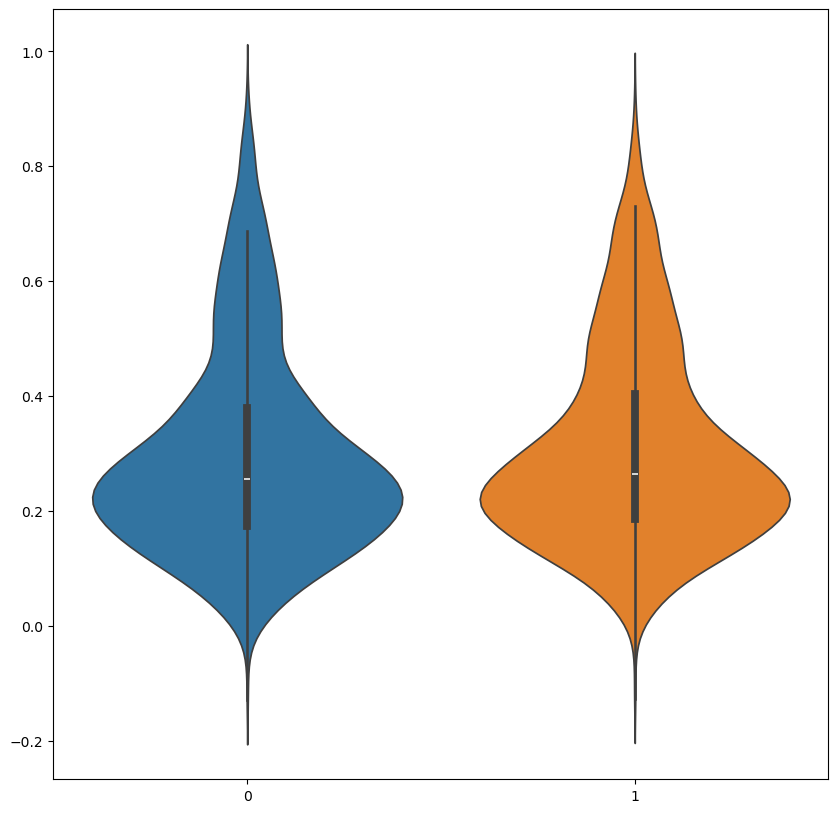

In [71]:
#do violin plot
plt.figure(figsize=(10,10))
sns.violinplot(data=[corrs_hyena, corrs_hyena_old[:,0]])